In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [4]:
df.dropna(inplace=True)   # Dropping the NULL values

In [5]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [6]:
df.shape

(714, 3)

### Model Building :

In [7]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
X_train.head(3)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000


In [10]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [11]:
y_pred = clf.predict(X_test)

print("Accuracy :",accuracy_score(y_test,y_pred))
print("Cross Val Score :",np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))

Accuracy : 0.6363636363636364
Cross Val Score : 0.6289319248826291


### Binning :

In [12]:
qbin_age = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
qbin_fare = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

### NOTE :

`n_bins` ==> The number of bins to produce.

`encode` ==> Method used to encode the transformed result. Default : `onehot`

`strategy` ==> Strategy used to define the widths of the bins. Default : `quantile`

In [13]:
trf = ColumnTransformer([('first',qbin_age,[0]),
                         ('second',qbin_fare,[1])
                        ])

In [14]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [15]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=15),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=15)}

In [16]:
# No. of Intervals
trf.named_transformers_['first'].n_bins_

array([15])

In [17]:
# Intervals (BINS)
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [18]:
output = pd.DataFrame({
                        'age' : X_train['Age'],
                        'age_trf' : X_train_trf[:,0],
                        'fare' : X_train['Fare'],
                        'fare_trf' : X_train_trf[:,1]
                      })

output.head()

,age,age_trf,fare,fare_trf
328,31.0,8.0,20.5250,8.0
73,26.0,6.0,14.4542,7.0
253,30.0,8.0,16.1000,7.0
719,33.0,9.0,7.7750,2.0
666,25.0,6.0,13.0000,6.0


In [19]:
output['age_labels'] = pd.cut(x= X_train['Age'],
                              bins= trf.named_transformers_['first'].bin_edges_[0].tolist())

output['fare_labels'] = pd.cut(x= X_train['Fare'],
                              bins= trf.named_transformers_['second'].bin_edges_[0].tolist())

In [20]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
660,50.0,13.0,133.6500,14.0,"(47.0, 54.0]","(108.9, 512.329]"
879,56.0,14.0,83.1583,13.0,"(54.0, 80.0]","(76.292, 108.9]"
288,42.0,12.0,13.0000,6.0,"(38.0, 42.0]","(10.5, 13.0]"
874,28.0,7.0,24.0000,8.0,"(25.0, 28.0]","(18.75, 26.0]"
634,9.0,1.0,27.9000,10.0,"(6.0, 16.0]","(26.55, 31.275]"


In [21]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)


DecisionTreeClassifier()

In [24]:
y_pred2 = clf.predict(X_test_trf)

print("Accuracy :",accuracy_score(y_test,y_pred2))

X_trf = trf.fit_transform(X)
print("Cross Val Score :",np.mean(cross_val_score(DecisionTreeClassifier(),X_trf,y,cv=10,scoring='accuracy')))

Accuracy : 0.6363636363636364
Cross Val Score : 0.6723004694835681


### General Function :

In [29]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
                            ('first',kbin_age,[0]),
                            ('second',kbin_fare,[1])
                            ])
                            
    X_trf = trf.fit_transform(X)
    print("Cross Val Score :",np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(11,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(11,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")


Cross Val Score : 0.6288928012519561


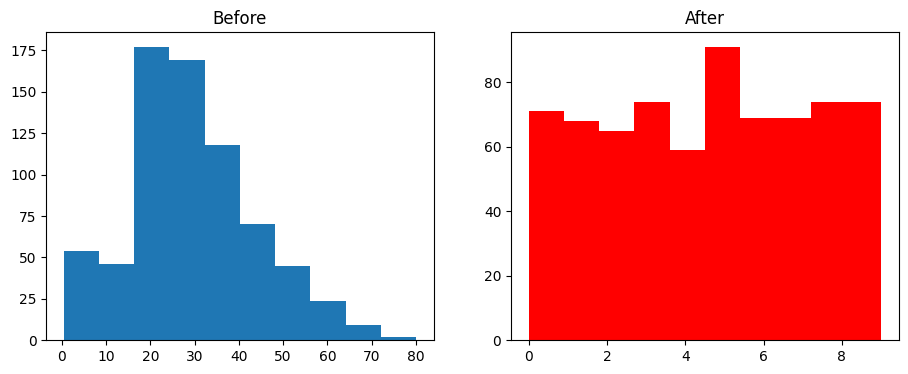

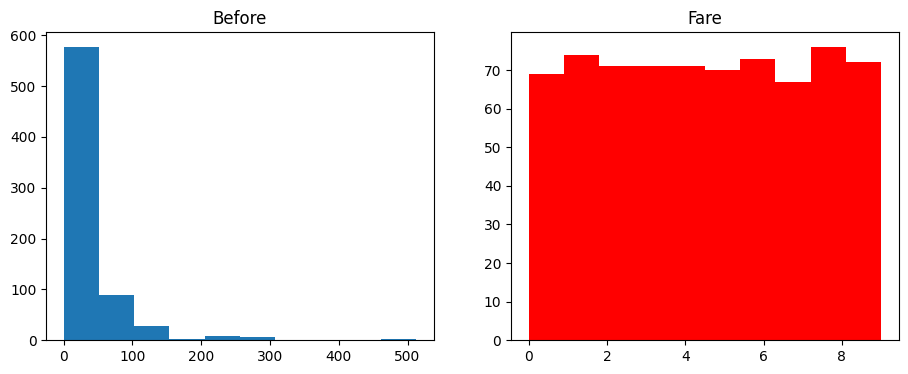

In [ ]:
discretize(10,'quantile')    # Quantile Binning

Cross Val Score : 0.6358763693270735


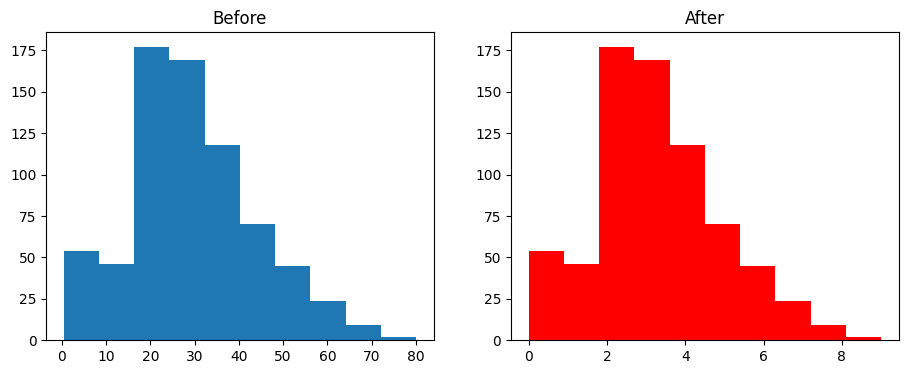

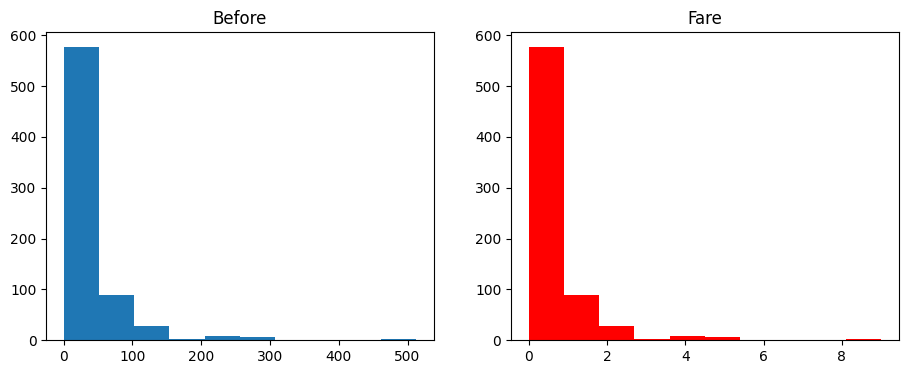

In [ ]:
discretize(10,'uniform')    # Uniform Binning

Cross Val Score : 0.6358959311424099


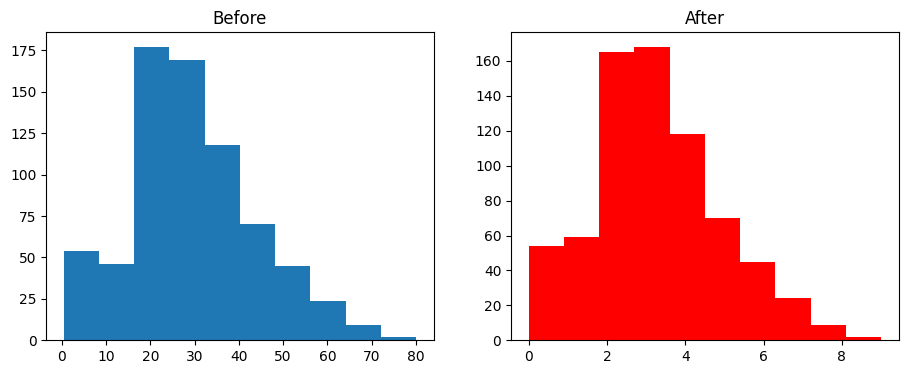

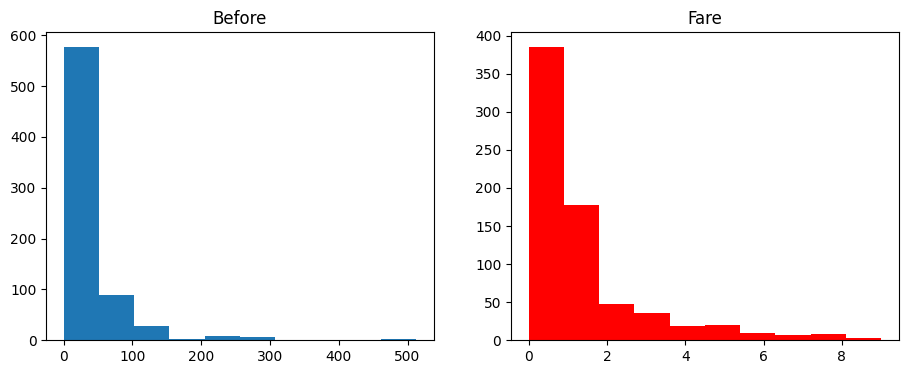

In [32]:
discretize(10,'kmeans')    # KMeans Binning

## Encoding Numerical Features :  
### 1. Discretization (Binning)
### 2. Binarization

`Discretization` is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range pf variable's values. 
- To handle outliers
- To improve the value spread

### Types of Discretization(Binning) :

1. `Unsupervised` 
    - Equal Width(Uniform) Binning  ==> All Bins Size are Equal
    - Equal Frequency(Quantile) Binning ==> Intervals contain equal % of total observations
    - KMeans Binning

1. `Supervised`
    - Decision Tree Binning

1. `Custom/Domain Based Binning`